In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('./DHT Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
# Step 3: Set 'Date' column as index
df.set_index('Date', inplace=True)

# Step 4: Sort the DataFrame based on index (Date) in descending order
df.sort_index(ascending=True, inplace=True)

# Step 5: Create a Series for plotting
df1 = df['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\khaqt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - loss: 0.0330 - val_loss: 0.0294
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - loss: 0.0046 - val_loss: 0.0765
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0019 - val_loss: 0.0512
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.0013 - val_loss: 0.0480
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - loss: 0.0011 - val_loss: 0.0392
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - loss: 8.9885e-04 - val_loss: 0.0307
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 444ms/step - loss: 7.5222e-04 - val_loss: 0.0230
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - loss: 5.7303e-04 - val_loss: 0.0156
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - loss: 3.8839e-04 - val_loss: 0.0085
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 2.6837e-04 - val_loss: 0.0039
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step - loss: 1.6147e-04 - val_loss: 0.0017
Epoch 12/100
15/

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [11]:
ytest_reshaped = ytest.reshape(-1, 1)

ytest_inverse = scaler.inverse_transform(ytest_reshaped)

In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest_inverse)**2))
test_mape = np.mean(np.abs((ytest_inverse - y_pred) / ytest_inverse)) * 100
test_msle = np.mean((np.log1p(ytest_inverse) - np.log1p(y_pred)) ** 2)

print('Testing RMSE:', test_rmse)
print('Test MAPE', test_mape)
print('Test MSLE', test_msle )

Testing RMSE: 714.8349573241727
Test MAPE 1.5897580930082071
Test MSLE 0.0006274635015882319


In [14]:
# Predict next 30, 60, and 90 days
last_sequence_days = df1[-30:].reshape(1, 30, 1)
y_next_30_days = []
y_next_60_days = []
y_next_90_days = []

for i in range(90):
    next_day_pred = model.predict(last_sequence_days)
    if i < 30:
        y_next_30_days.append(next_day_pred[0][0])
    if i < 60:
        y_next_60_days.append(next_day_pred[0][0])
    y_next_90_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [15]:
# Inverse transform the predictions
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1)).flatten()

In [16]:
y_next_30_days

array([39847.867, 39882.176, 39822.824, 39760.   , 39695.703, 39631.477,
       39567.625, 39504.098, 39440.76 , 39377.523, 39314.28 , 39250.93 ,
       39187.383, 39123.434, 39058.895, 38993.965, 38929.137, 38864.74 ,
       38800.297, 38735.64 , 38671.   , 38606.562, 38542.227, 38477.844,
       38413.387, 38348.96 , 38284.926, 38221.227, 38157.78 , 38094.746],
      dtype=float32)

In [17]:
# Print lengths
print("Length of y_next_30_days:", len(y_next_30_days))
print("Length of y_next_60_days:", len(y_next_60_days))
print("Length of y_next_90_days:", len(y_next_90_days))

Length of y_next_30_days: 30
Length of y_next_60_days: 60
Length of y_next_90_days: 90


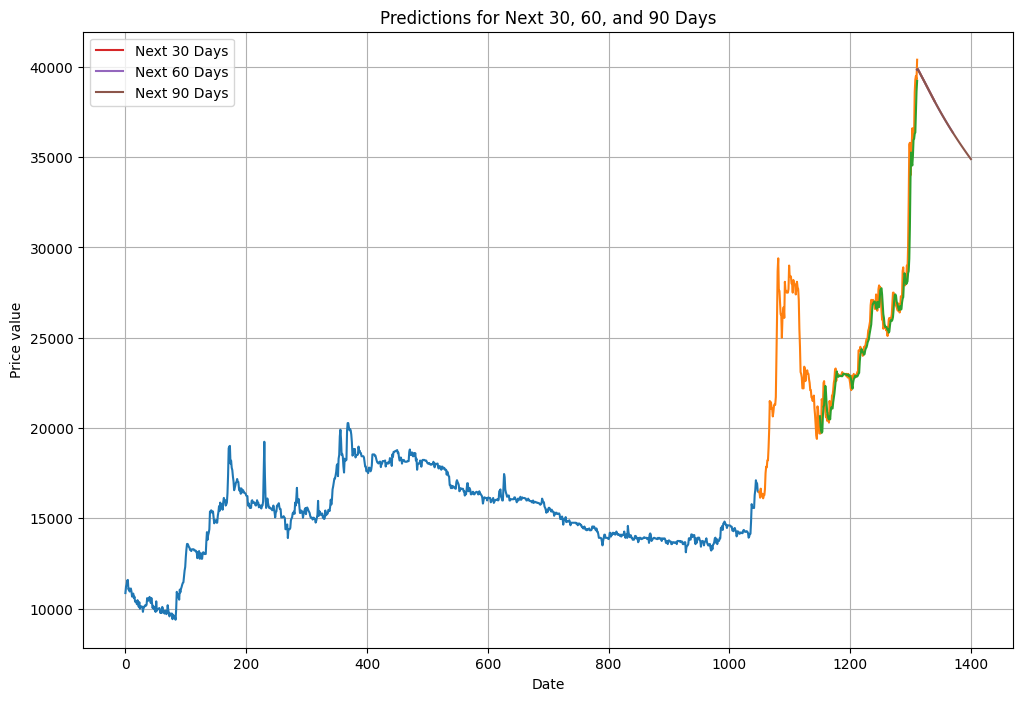

In [18]:
# Create date ranges for next 30, 60, and 90 days
next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
next_60_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
next_90_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)


# Plot the predictions
plt.figure(figsize=(12, 8))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
plt.plot(next_30_days_index, y_next_30_days, label='Next 30 Days')
plt.plot(next_60_days_index, y_next_60_days, label='Next 60 Days')
plt.plot(next_90_days_index, y_next_90_days, label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("Predictions for Next 30, 60, and 90 Days")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('next_days_predictions.png')
plt.show()